In [1]:
from platform import python_version
print("VERSION: ", python_version()) # expect 3.7.0

VERSION:  3.7.0


In [2]:
import pandas as pd
import numpy as np
import json
import string
import matplotlib.pyplot as plt
from importlib import reload
from matplotlib.pyplot import figure
import datetime

# zoomies
import dask.dataframe as dd
from dask.multiprocessing import get
from multiprocessing import cpu_count

# custom data loading functions
import load_data
import clean_data
import custom_feature_extraction
import custom_keras_metrics


from tensorflow.metrics import auc as tf_auc
from tensorflow import local_variables_initializer
import keras
import keras.backend as K
from keras.models import model_from_yaml
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Conv2D, \
        MaxPooling1D, LSTM, Flatten, BatchNormalization,Embedding,Reshape, Dropout

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import sklearn.cluster as sc
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.cluster.hierarchy import ward, dendrogram

/usr/local/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.24) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)
Using TensorFlow backend.


In [3]:
# dirty spaCy error workaround:
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

In [4]:
full_data ='../data/data_turk/ALL_CANDIDATES.json'

In [5]:
# reload(load_data)
df = load_data.getJSONData(full_data)
df.head()

,annotation,fileID,text
0,NON_permission_statement.,1,a copy of this entire consent form will be giv...
1,NON_permission_statement,1,"""what if i change my mind about participating ..."
2,NON_permission_statement,1,ask your study doctor for more information abo...
3,NON_permission_statement,1,newborn screening required additional language...
4,NON_permission_statement,1,"""if you are a healthy volunteer, no direct med..."


In [6]:
print(len(df))

20000


In [7]:
backup = df
pred_df = df

In [8]:
vocabulary_size = 1000
maxlen = 100

tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(pred_df['text'])
sequences = tokenizer.texts_to_sequences(pred_df['text'])
data = pad_sequences(sequences, maxlen=maxlen)

In [9]:
pred_df['data'] = data.tolist()
pred_df['data'].head(10)

0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
5    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
6    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
7    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
8    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
9    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: data, dtype: object

In [10]:
new_col_names = ['seq_posi' + str(i) for i in range(0,maxlen)]
pos_seq_df = pd.DataFrame(pred_df['data'].values.tolist(), columns=new_col_names)
pred_df = pd.concat([pred_df, pos_seq_df], axis=1)
pred_df.head()

,annotation,fileID,text,data,seq_posi0,seq_posi1,seq_posi2,seq_posi3,seq_posi4,seq_posi5,...,seq_posi90,seq_posi91,seq_posi92,seq_posi93,seq_posi94,seq_posi95,seq_posi96,seq_posi97,seq_posi98,seq_posi99
0,NON_permission_statement.,1,a copy of this entire consent form will be giv...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,...,3,9,749,18,27,13,8,54,2,87
1,NON_permission_statement,1,"""what if i change my mind about participating ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,...,678,182,6,19,2,8,7,9,17,10
2,NON_permission_statement,1,ask your study doctor for more information abo...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,...,153,22,38,67,166,4,56,13,8,204
3,NON_permission_statement,1,newborn screening required additional language...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,...,518,77,18,147,135,75,3,75,261,785
4,NON_permission_statement,1,"""if you are a healthy volunteer, no direct med...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,...,10,4,74,23,8,194,72,16,866,219


### Load the model

In [11]:
model_path = '../models/CNN_model2019-04-11.h5'
mapping_path = '../models/CNN_model2019-04-11.yaml'

In [12]:
# load YAML and create model
yaml_file = open(mapping_path, 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml)
# load weights into new model
loaded_model.load_weights(model_path)
print("Loaded model from disk")


/usr/local/lib/python3.7/site-packages/keras/engine/saving.py:473: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(yaml_string)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded model from disk


In [13]:
predictions = loaded_model.predict_classes(pred_df[new_col_names])

In [14]:
sum(predictions)

2282

In [15]:
print(len(predictions))

20000


In [16]:
df['predictions'] = predictions.tolist()

In [17]:
df.head()

,annotation,fileID,text,data,predictions
0,NON_permission_statement.,1,a copy of this entire consent form will be giv...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
1,NON_permission_statement,1,"""what if i change my mind about participating ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
2,NON_permission_statement,1,ask your study doctor for more information abo...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
3,NON_permission_statement,1,newborn screening required additional language...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
4,NON_permission_statement,1,"""if you are a healthy volunteer, no direct med...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0


In [18]:
positives_df = df.loc[df['predictions'] == 1]
print(len(positives_df))

2282


In [38]:
agg_df = positives_df.groupby('fileID').count()

agg_df.head()

print(np.mean(agg_df['predictions']))
print(np.std(agg_df['predictions']))

5.294663573085847
6.232460814979168


In [42]:
print(positives_df['fileID'].nunique())
print(df['fileID'].nunique())

print(positives_df['fileID'].nunique()/df['fileID'].nunique())

431
603
0.714759535655058


In [19]:
for idx, row in positives_df.head(10).iterrows():
    print(row['fileID'], row['text'], '\n')

1 i give my permission for my xxx records to be accessed for use in this research study. 

1 "if you decide you do not want to participate, there will be no penalty to you, and you will not lose any benefits you normally would have." 

1 representatives from these entities can see information that has your name on it if they come to the study site to view records. 

1 language for required recordings: the researchers will take photographs/make an audio and/or video recording during the study so that purpose. 

1 : the alternative is to sign up for another study or to choose to complete another assignment as described in your syllabus. 

1 information about you and related to this study will be kept confidential to the extent permitted or required by law. 

1 contracts with texas sponsors may include language indicating joint ownership of the data-this information should be included in the consent document 5. 

1 i do not give my permission for my xxx records to be accessed for use in t

### Let's do some clustering!

In [20]:
ngramSize = 5
maxTermFrequencyThreshold = .99
minTermFrequencyThreshold = .1
corpus = df['text']

def getTDIDFMatrix(corpus, ngram_range, max_df, min_df):
    """ return td-idf matrix and terms """
    
    tfidf_vectorizer = TfidfVectorizer(use_idf=True, 
                                       ngram_range=(1,ngram_range),
                                       max_df=max_df,min_df=min_df)
    
    tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
    terms = tfidf_vectorizer.get_feature_names()
    
    return tfidf_matrix, terms

# save to a variable 
tdidf_matrix, tdidf_terms = getTDIDFMatrix(corpus, 
                                           ngramSize, 
                                           maxTermFrequencyThreshold,
                                           minTermFrequencyThreshold)

# print tests
print('tdidf matrix type:', type(tdidf_matrix)) # will need to handle
print('terms type:', type(tdidf_terms))

print('\nfirst few terms:')
[print(" ", x) for x in tdidf_terms[:10]]

print('\nNumber of terms:', len(tdidf_terms))

tdidf matrix type: <class 'scipy.sparse.csr.csr_matrix'>
terms type: <class 'list'>

first few terms:
  and
  any
  are
  as
  be
  by
  consent
  for
  form
  have

Number of terms: 35


In [21]:
[print(x) for x in tdidf_terms[:10]]


and
any
are
as
be
by
consent
for
form
have


[None, None, None, None, None, None, None, None, None, None]

In [22]:
# sdf = pd.SparseDataFrame(tdidf_matrix, columns=tdidf_terms)

# sdf['FileName'] = positives_df['fileID']

# sdf.head()

In [23]:
print(type(tdidf_matrix))
print(dir(tdidf_matrix))

<class 'scipy.sparse.csr.csr_matrix'>
['__abs__', '__add__', '__array_priority__', '__bool__', '__class__', '__delattr__', '__dict__', '__dir__', '__div__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__idiv__', '__imul__', '__init__', '__init_subclass__', '__isub__', '__iter__', '__itruediv__', '__le__', '__len__', '__lt__', '__matmul__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__nonzero__', '__pow__', '__radd__', '__rdiv__', '__reduce__', '__reduce_ex__', '__repr__', '__rmatmul__', '__rmul__', '__rsub__', '__rtruediv__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', '__truediv__', '__weakref__', '_add_dense', '_add_sparse', '_arg_min_or_max', '_arg_min_or_max_axis', '_binopt', '_boolean_index_to_array', '_check_boolean', '_check_ellipsis', '_cs_matrix__get_has_canonical_format', '_cs_matrix__get_sorted', '_cs_matrix__set_has_canonical_format'

In [24]:
num_clusters = 4

# dict of different clustering models to run
models_to_fit = {
    'KMeans': sc.KMeans(num_clusters),
#     'SpectralClustering': sc.SpectralClustering(num_clusters),
#     'AgglomerativeClustering': sc.AgglomerativeClustering(num_clusters),
#     'Birch': sc.Birch(threshold=0.1), # lower thresh promotes splitting    
    }

# dict to save fitted models
cluster_models = {}

# fit each model and save to dict
for k,v in models_to_fit.items():
    model = v
    model.fit(tdidf_matrix.toarray()) # all can handle dense, some cannot handle sparse
    
    cluster_models[k] = {}
    cluster_models[k]['fit'] = model
    cluster_models[k]['labels'] = model.labels_.tolist()
    

In [25]:
for k,v in cluster_models.items():
    df[k] = v['labels']

In [26]:
def getTopTerms(model, n_clusters, terms, n_terms):
    """ return the top n term of the clusters
    sorted by proximity to centroid """
    
    if hasattr(model, 'cluster_centers_'):
        if type(model.cluster_centers_) is np.ndarray: # handle sparse matrix
            # sort cluster centers by proximity to centroid
            order_centroids = model.cluster_centers_.argsort()[:, ::-1] 
        else:
            order_centroids = model.cluster_centers_.toarray().argsort()[:, ::-1]  

        # dict to hold index to string translation 
        top_terms = {}

        for i in range(n_clusters):
            cluster_list = []

            for ind in order_centroids[i, :n_terms]: 
                cluster_list.append(terms[ind])

            top_terms[i] = cluster_list

        return top_terms

# print out results for top n terms
n = 5
for k,v in cluster_models.items():
    print('top terms for ', k)
    
    try:
        terms = getTopTerms(v['fit'],v['n_clusters'],tdidf_terms, n) # n
        [print(k,v) for k,v in terms.items()]
        print('\n')
    except:
        print('No Available Cluster Centers\n')

top terms for  KMeans
No Available Cluster Centers



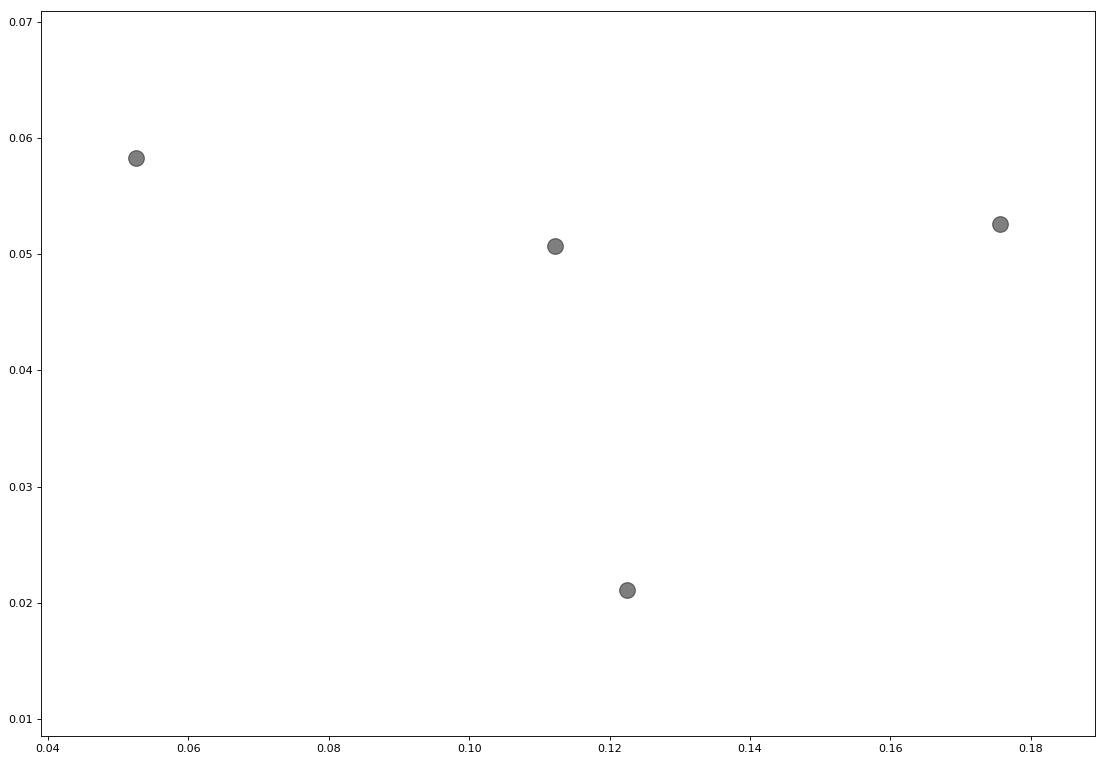

In [27]:
%matplotlib inline
figure(num=None, figsize=(17, 12), dpi=80, facecolor='w', edgecolor='k')
    
centers = cluster_models['KMeans']['fit'].cluster_centers_
plt.scatter(centers[:, 0], 
            centers[:, 1], 
            c='black', 
            s=200, 
            alpha=0.5)

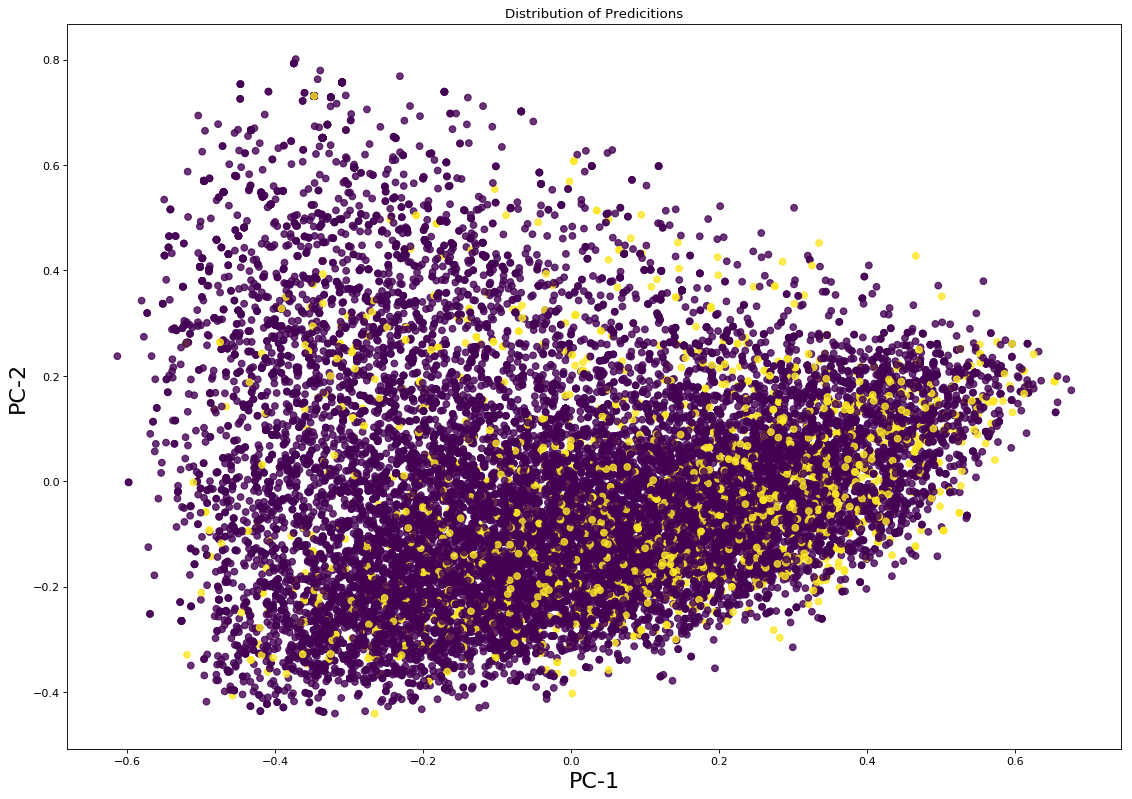

In [29]:
from sklearn.decomposition import PCA

figure(num=None, figsize=(17, 12), dpi=80, facecolor='w', edgecolor='k')

pca = PCA(n_components=2).fit(tdidf_matrix.todense())
data2D = pca.transform(tdidf_matrix.todense())
plt.scatter(data2D[:,0], 
            data2D[:,1], 
            c=df['predictions'], 
            marker='o',
            alpha=.8)
plt.xlabel('PC-1', fontsize=20)
plt.ylabel('PC-2', fontsize=20)
plt.title('Distribution of Predicitions')
plt.show()   